In [1]:
#@Demo4_AdvectionDiffusionReaction
# Setup system environment and define utility functions and variables
from google.colab import files
try:
    from dolfin import *; from mshr import *
except ImportError as e:
    !apt-get install -y -qq software-properties-common python-software-properties module-init-tools
    !add-apt-repository -y ppa:fenics-packages/fenics
    !apt-get update -qq
    !sed -e 's:artful:bionic:' /etc/apt/sources.list.d/fenics-packages-ubuntu-fenics-artful.list > temp
    !mv temp /etc/apt/sources.list.d/fenics-packages-ubuntu-fenics-artful.list
    !sed -e 's:artful:bionic:' /etc/apt/sources.list > temp
    !mv temp /etc/apt/sources.list
    !apt-get update -qq
    !apt install -y --no-install-recommends fenics    
    from dolfin import *; from mshr import *
    
import matplotlib.pyplot as plt;
from IPython.display import clear_output, display, update_display; import time; import dolfin.common.plotting as fenicsplot 
import time
from ufl import replace

def plot_compact(u, t, stepcounter, QQ, pl, ax, label = "Velocity", clear = True): # Compact plot utility function
  if stepcounter == 0:
    pl, ax = plt.subplots(); display(pl);
    if clear:
      clear_output(); # Plotting setup
  if stepcounter % 5 == 0:
    uEuclidnorm = project(sqrt(inner(u, u)), QQ); ax.cla(); fig = plt.gcf(); fig.set_size_inches(16, 4)
    plt.subplot(1, 2, 1); pp = plot(uEuclidnorm, cmap="coolwarm", label=label); plt.title("%s at t=%f" % (label, t)) # Plot norm of velocity
    if t == 0.: plt.axis(G); plt.colorbar(pp, shrink=0.5); 
    #plt.subplot(1, 2, 2);
    #if t == 0.: Q.mesh(); plt.title("Mesh") # Plot mesh
    plt.tight_layout(); dpl = display(pl, display_id="test");
  return (pl, ax)

def plot_compact_static(u, QQ, label = "Velocity"): # Compact plot utility function
  pl, ax = plt.subplots();display(pl);
  uEuclidnorm = project(sqrt(inner(u, u)), QQ); ax.cla(); fig = plt.gcf(); fig.set_size_inches(16, 4)
  plt.subplot(1, 2, 1); pp = plot(uEuclidnorm, cmap="coolwarm"); plt.title("%s" % (label)) # Plot norm of velocity
  plt.axis(G);plt.colorbar(pp, shrink=0.5); 
  plt.subplot(1, 2, 2);
  plot(Q.mesh()); plt.title("Mesh") # Plot mesh
  plt.tight_layout();dpl = display(pl, display_id="test");
  return (pl, ax)


E: Package 'python-software-properties' has no installation candidate
Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran35/ InRelease [3,626 B]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:3 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Ign:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:7 http://ppa.launchpad.net/fenics-packages/fenics/ubuntu bionic InRelease [15.4 kB]
Hit:8 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:9 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran35/ Packages [74.7 kB]
Hit:11 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Get:12 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]

time: 0
u max: 2.7395423754029684
time: 0.001
u max: 3.0540548165198236
time: 0.002
u max: 2.545058468418341
time: 0.003
u max: 2.34642901412307
time: 0.004
u max: 2.3007818040786185
time: 0.005
u max: 2.2423722757127895
time: 0.006
u max: 2.211293063080422
time: 0.007
u max: 2.2041650359059513
time: 0.008
u max: 2.1777773511516187
time: 0.009000000000000001
u max: 2.1385513899306923
time: 0.010000000000000002
u max: 2.092446653397678
time: 0.011000000000000003
u max: 2.044449486036221
time: 0.012000000000000004
u max: 1.9984657727110542
time: 0.013000000000000005
u max: 1.9572729987292357
time: 0.014000000000000005
u max: 1.9729039513861206
time: 0.015000000000000006
u max: 1.9870920979137892
time: 0.016000000000000007
u max: 1.9968313882642932
time: 0.017000000000000008
u max: 2.002679514796767
time: 0.01800000000000001
u max: 2.0052827734914542
time: 0.01900000000000001
u max: 2.0053313593600564
time: 0.02000000000000001
u max: 2.00351234355978
time: 0.02100000000000001
u max: 2.000

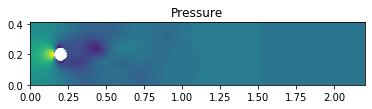

In [10]:
"""
FEniCS tutorial demo program: Incompressible Navier-Stokes equations
for flow around a cylinder using the Incremental Pressure Correction
Scheme (IPCS).

  u' + u . nabla(u)) - div(sigma(u, p)) = f
                                 div(u) = 0
"""

from __future__ import print_function
from fenics import *
from mshr import *
import numpy as np

T = 1.0        # final time
num_steps = 1000   # number of time steps
dt = T / num_steps # time step size
mu = 0.001         # dynamic viscosity
rho = 1            # density

# Create mesh
channel = Rectangle(Point(0, 0), Point(2.2, 0.41))
cylinder = Circle(Point(0.2, 0.2), 0.05)
domain = channel - cylinder
mesh = generate_mesh(domain, 64)

# Define function spaces
V = VectorFunctionSpace(mesh, 'P', 2)
Q = FunctionSpace(mesh, 'P', 1)

# Define boundaries
inflow   = 'near(x[0], 0)'
outflow  = 'near(x[0], 2.2)'
walls    = 'near(x[1], 0) || near(x[1], 0.41)'
cylinder = 'on_boundary && x[0]>0.1 && x[0]<0.3 && x[1]>0.1 && x[1]<0.3'

# Define inflow profile
inflow_profile = ('4.0*1.5*x[1]*(0.41 - x[1]) / pow(0.41, 2)', '0')

# Define boundary conditions
bcu_inflow = DirichletBC(V, Expression(inflow_profile, degree=2), inflow)
bcu_walls = DirichletBC(V, Constant((0, 0)), walls)
bcu_cylinder = DirichletBC(V, Constant((0, 0)), cylinder)
bcp_outflow = DirichletBC(Q, Constant(0), outflow)
bcu = [bcu_inflow, bcu_walls, bcu_cylinder]
bcp = [bcp_outflow]

# Define trial and test functions
u = TrialFunction(V)
v = TestFunction(V)
p = TrialFunction(Q)
q = TestFunction(Q)

# Define functions for solutions at previous and current time steps
u_n = Function(V)
u_  = Function(V)
p_n = Function(Q)
p_  = Function(Q)

# Define expressions used in variational forms
U  = 0.5*(u_n + u)
n  = FacetNormal(mesh)
f  = Constant((0, 0))
k  = Constant(dt)
mu = Constant(mu)
rho = Constant(rho)

# Define symmetric gradient
def epsilon(u):
    return sym(nabla_grad(u))

# Define stress tensor
def sigma(u, p):
    return 2*mu*epsilon(u) - p*Identity(len(u))

# Define variational problem for step 1
F1 = rho*dot((u - u_n) / k, v)*dx \
   + rho*dot(dot(u_n, nabla_grad(u_n)), v)*dx \
   + inner(sigma(U, p_n), epsilon(v))*dx \
   + dot(p_n*n, v)*ds - dot(mu*nabla_grad(U)*n, v)*ds \
   - dot(f, v)*dx
a1 = lhs(F1)
L1 = rhs(F1)

# Define variational problem for step 2
a2 = dot(nabla_grad(p), nabla_grad(q))*dx
L2 = dot(nabla_grad(p_n), nabla_grad(q))*dx - (1/k)*div(u_)*q*dx

# Define variational problem for step 3
a3 = dot(u, v)*dx
L3 = dot(u_, v)*dx - k*dot(nabla_grad(p_ - p_n), v)*dx

# Assemble matrices
A1 = assemble(a1)
A2 = assemble(a2)
A3 = assemble(a3)

# Apply boundary conditions to matrices
[bc.apply(A1) for bc in bcu]
[bc.apply(A2) for bc in bcp]

# Create XDMF files for visualization output
xdmffile_u = XDMFFile('velocity.xdmf')
xdmffile_p = XDMFFile('pressure.xdmf')

# Create time series (for use in reaction_system.py)
timeseries_u = TimeSeries('velocity_series')
timeseries_p = TimeSeries('pressure_series')

# Save mesh to file (for use in reaction_system.py)
File('cylinder.xml.gz') << mesh

# Time-stepping
t = 0
for n in range(num_steps):

    # Update current time
    print("time:",t)
    t += dt

    # Step 1: Tentative velocity step
    b1 = assemble(L1)
    [bc.apply(b1) for bc in bcu]
    solve(A1, u_.vector(), b1, 'bicgstab', 'hypre_amg')

    # Step 2: Pressure correction step
    b2 = assemble(L2)
    [bc.apply(b2) for bc in bcp]
    solve(A2, p_.vector(), b2, 'bicgstab', 'hypre_amg')

    # Step 3: Velocity correction step
    b3 = assemble(L3)
    solve(A3, u_.vector(), b3, 'cg', 'sor')

    # Plot solution
    plot(u_, title='Velocity')
    plot(p_, title='Pressure')

    # Save solution to file (XDMF/HDF5)
    xdmffile_u.write(u_, t)
    xdmffile_p.write(p_, t)

    # Save nodal values to file
    timeseries_u.store(u_.vector(), t)
    timeseries_p.store(p_.vector(), t)

    # Update previous solution
    u_n.assign(u_)
    p_n.assign(p_)

    print('u max:', u_.vector()[:].max())


In [18]:
from google.colab import files
files.upload()

Saving velocity_series.h5 to velocity_series.h5


In [20]:
from google.colab import files
files.upload()

Saving cylinder.xml.gz to cylinder.xml.gz


{'cylinder.xml.gz': b'\x1f\x8b\x08\x00\x00\x00\x00\x00\x00\xff\xac\xbd\xeb\x92l9v\x9c\xf9_O\xd1\xd6\x7fe\x93\xc4\xfd"#\xa5g\x19#KR\x8f\xf1f$m\x8c\x9c\xa7\x1f\xffV\x04\x10\xc0a\xc6Y\x15GU\xddlvW\xd6A\xee\xbd\x01\xac\xab/\xf7\xbf\xfe\x1f\xff\xfe\x0f\x7f\xff\xa7\xff\xf7\xb7\x7f\xf9\xd7\xbf\xfc\xd3?\xfe\xcd\x9f\xe3W\xf8\xf3\xff\xf8\xef\xff\xe5\xaf\xff\xee\x9f\xfe\xfe\x7f\xfe\xe5\x1f\xff\xa4\x9f\xfd\xe3\xbf\xfe\xb7\xc7\xff\xf8\x9b?\xff\xef\x7f\xfb\xb7\x7f\xfeo\x7f\xf5W\xff\xf3\xb7\x7f\xfc\xcb\xdf\xfe\xeb?\xff\xcb?\xfd?\xbf\xfd\xed\xbf}\xfd\xd3\xbf\xfc\xaf?\xff\xf7\xff\xf2\xa7?\xfd\xf5?\xfc\xf6\xaf\xff\xfbO\x7f\xfb\xdb\xdf\xff\xfd\xbf\xfd\xc7?\xff\xf67\x7f\xfe\xb7\x7f\xf9\xcb\xff\xfd\x8f\xff\xeb\xef\x7f\xfb\xf3\x9f\xfe\xee/\xff\xf07\x7fN\xf6\x0f\xe9\x1f\xd3\xaf\xfa\xb7\xbf\xfc\xedo\xff\xfa\xa7\x7f\xfd\xcb\xff\xa7\x7f,\x95\xd2\x9e?z\xfe\xf0\xb7\x7f\xff\xd3_\xfe\xf1\xef~\xfb\xf7\xbf\xf9s\xf8\xf3\x9f\xf8\xcf\xafp\xff\xf5\xdb\x7f\r\xfa\xc9\x7f\xfc\xcd\x9f\xcbW\xfc\xe1\'\xffW\x88\x7f\xfe\xd3_\xbd

In [0]:
"""
FEniCS tutorial demo program: Convection-diffusion-reaction for a system
describing the concentration of three species A, B, C undergoing a simple
first-order reaction A + B --> C with first-order decay of C. The velocity
is given by the flow field w from the demo navier_stokes_cylinder.py.

  u_1' + w . nabla(u_1) - div(eps*grad(u_1)) = f_1 - K*u_1*u_2
  u_2' + w . nabla(u_2) - div(eps*grad(u_2)) = f_2 - K*u_1*u_2
  u_3' + w . nabla(u_3) - div(eps*grad(u_3)) = f_3 + K*u_1*u_2 - K*u_3

"""

from __future__ import print_function
from fenics import *

T = 5.0            # final time
num_steps = 500    # number of time steps
dt = T / num_steps # time step size
eps = 0.01         # diffusion coefficient
K = 10.0           # reaction rate

# Read mesh from file
mesh = Mesh('cylinder.xml.gz')

# Create mesh, same mesh as cylinder.xml.gz
#channel = Rectangle(Point(0, 0), Point(2.2, 0.41))
#cylinder = Circle(Point(0.2, 0.2), 0.05)
#domain = channel - cylinder
#mesh = generate_mesh(domain, 64)

# Define function space for velocity
W = VectorFunctionSpace(mesh, 'P', 2)

# Define function space for system of concentrations
P1 = FiniteElement('P', triangle, 1)
element = MixedElement([P1, P1, P1])
V = FunctionSpace(mesh, element)

# Define test functions
v_1, v_2, v_3 = TestFunctions(V)

# Define functions for velocity and concentrations
w = Function(W)
u = Function(V)
u_n = Function(V)

# Split system functions to access components
u_1, u_2, u_3 = split(u)
u_n1, u_n2, u_n3 = split(u_n)

# Define source terms
f_1 = Expression('pow(x[0]-0.1,2)+pow(x[1]-0.1,2)<0.05*0.05 ? 0.1 : 0',
                 degree=1)
f_2 = Expression('pow(x[0]-0.1,2)+pow(x[1]-0.3,2)<0.05*0.05 ? 0.1 : 0',
                 degree=1)
f_3 = Constant(0)

# Define expressions used in variational forms
k = Constant(dt)
K = Constant(K)
eps = Constant(eps)

# Define variational problem
F = ((u_1 - u_n1) / k)*v_1*dx + dot(w, grad(u_1))*v_1*dx \
  + eps*dot(grad(u_1), grad(v_1))*dx + K*u_1*u_2*v_1*dx  \
  + ((u_2 - u_n2) / k)*v_2*dx + dot(w, grad(u_2))*v_2*dx \
  + eps*dot(grad(u_2), grad(v_2))*dx + K*u_1*u_2*v_2*dx  \
  + ((u_3 - u_n3) / k)*v_3*dx + dot(w, grad(u_3))*v_3*dx \
  + eps*dot(grad(u_3), grad(v_3))*dx - K*u_1*u_2*v_3*dx + K*u_3*v_3*dx \
  - f_1*v_1*dx - f_2*v_2*dx - f_3*v_3*dx

# Create time series for reading velocity data
timeseries_w = TimeSeries('velocity_series')

# Create VTK files for visualization output
vtkfile_u_1 = File('u_1.pvd')
vtkfile_u_2 = File('u_2.pvd')
vtkfile_u_3 = File('u_3.pvd')

# Time-stepping
t = 0
for n in range(num_steps):

    # Update current time
    t += dt

    # Read velocity from file
    timeseries_w.retrieve(w.vector(), t)

    # Solve variational problem for time step
    solve(F == 0, u)

    # Save solution to file (VTK)
    _u_1, _u_2, _u_3 = u.split()
    vtkfile_u_1 << (_u_1, t)
    vtkfile_u_2 << (_u_2, t)
    vtkfile_u_3 << (_u_3, t)

    # Update previous solution
    u_n.assign(u)

